In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
# Standard library imports.
import itertools
import json

# Related third party imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,6)

# Local application/library specific imports.

# def add_cumulative(df, sim_timesteps: int = 50):
#     n_simulation = int(len(df) / sim_timesteps)
#     for i in range(n_simulation):
#         mask = list(range(i*sim_timesteps, (i+1)*sim_timesteps))
#         df.loc[mask,'acceptable_count_cum'] = df.loc[mask,'acceptable_count'].cumsum()
#         df.loc[mask,'vSDN_count_cum'] = df.loc[mask,'vSDN_count'].cumsum()
#         df.loc[mask,'acceptance_ratio_cum'] = df.loc[mask,'acceptable_count_cum'] / df.loc[mask,'vSDN_count_cum']


def add_cumulative(df):
    for sim_name in df['simulation_name'].unique():
        for sim_id in df['simulation_id'].unique():
            mask = (df['simulation_id'] == sim_id) & (df['simulation_name'] == sim_name)
            df.loc[mask,'acceptable_count_cum'] = df.loc[mask,'acceptable_count'].cumsum()
            df.loc[mask,'vSDN_count_cum'] = df.loc[mask,'vSDN_count'].cumsum()
            df.loc[mask,'acceptance_ratio_cum'] = df.loc[mask,'acceptable_count_cum'] / df.loc[mask,'vSDN_count_cum']

def get_mean(df, sim_timesteps: int = 50):
    df_ = df.drop(labels=['h_list', 'switch_hpair_count'], axis=1)
    return df_.groupby(by=['simulation_name', 'timestep'], as_index=False).mean()

# def get_mean(df, sim_timesteps: int = 50):
#     print(df.shape)
#     df_ = df.drop(labels=['h_list', 'switch_hpair_count'], axis=1)
#     print(df_.shape)
#     simulation_size = sim_timesteps * len(df_['simulation_id'].unique())
#     n_simulation = int(len(df_) / simulation_size)
#     df_mean = pd.DataFrame()
#     for i in range(n_simulation):
#         print(df_mean.shape)
#         mask = list(range(i*simulation_size, (i+1)*simulation_size))
#         df_mean = pd.concat([df_mean,df_.loc[mask,:].groupby(by='timestep', as_index=False).mean()], ignore_index=True)
#     return df_mean

## Save json to csv

In [5]:
network = '25_italy'
simulation_date = '2021-11-08'
placement_type = 'heu-hco'

df = pd.read_json(f"../results/{network}/{simulation_date}-{network}-{placement_type}.json")
df.latency_factor = df.latency_factor.round(1)

In [43]:
df.to_csv(f"../results/{network}/2021-11-04-{network}-ilp-hco.csv", index=False)

In [6]:
df.query(" vSDN_size == 2 ")

,acceptable_count,acceptance_ratio,acceptance_ratio_ilp,chs_avg,chs_avg_b,chs_avg_p,chs_max_b,chs_max_p,cp_objective,diameter,...,max_length,network,request_processing_time,shortest_k,vSDN_count,vSDN_count_ilp,vSDN_coverage,vSDN_generator_seed,vSDN_max_size_ilp,vSDN_size
0,12,0.352941,NaN,0,56,4,152,99,random,1586,...,158,25_italy,0.00,16,34,0,1.0,123,0,2
12,0,0.000000,NaN,0,-1,-1,-1,-1,random,1586,...,158,25_italy,0.00,16,34,0,1.0,123,0,2
24,0,0.000000,NaN,0,-1,-1,-1,-1,random,1586,...,158,25_italy,0.00,16,34,0,1.0,123,0,2
36,0,0.000000,NaN,0,-1,-1,-1,-1,random,1586,...,158,25_italy,0.00,16,34,0,1.0,123,0,2
48,0,0.000000,NaN,0,-1,-1,-1,-1,random,1586,...,158,25_italy,0.00,16,34,0,1.0,123,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,34,1.000000,NaN,0,1473,1356,1585,1581,random,1586,...,1586,25_italy,0.71,16,34,0,1.0,123,0,2
1152,34,1.000000,NaN,0,1485,1390,1585,1575,random,1586,...,1586,25_italy,0.89,16,34,0,1.0,123,0,2
1164,34,1.000000,NaN,0,1475,1372,1585,1582,random,1586,...,1586,25_italy,0.68,16,34,0,1.0,123,0,2
1176,34,1.000000,NaN,0,1463,1356,1585,1583,random,1586,...,1586,25_italy,1.09,16,34,0,1.0,123,0,2


## Analyse Data

In [78]:
network = '25_italy'
simulation_date = '2021-11-14'

placement_type = 'ilp-acc'
# dfa = pd.read_json(f"../results/{network}/dynamic/{simulation_date}-{network}-{placement_type}.json")
# dfa.latency_factor = dfa.latency_factor.round(1)
dfa = pd.read_json("../results/25_italy/dynamic/2021-11-15-20-17-25_italy-ilp-acc.json")
add_cumulative(dfa)
dfa = get_mean(dfa)
dfa['latency_factor'] = dfa['latency_factor'].round(2)

placement_type = 'ilp-opt'
# dfo = pd.read_json(f"../results/{network}/dynamic/{simulation_date}-{network}-{placement_type}.json")
# dfo.latency_factor = dfo.latency_factor.round(1)
dfo = pd.read_json("../results/25_italy/dynamic/2021-11-15-22-38-25_italy-ilp-opt.json")
add_cumulative(dfo)
dfo = get_mean(dfo)
dfo['latency_factor'] = dfo['latency_factor'].round(2)


In [ ]:
dfa.query("latency_factor == 0.55")[['hp_runtime', 'acceptance_ratio', 'acceptance_ratio_cum', 'active_vSDN_count', 'mean_switch_hpair_count', 'timestep']]

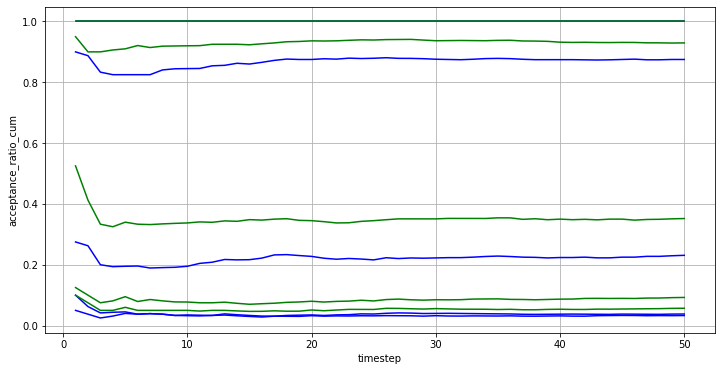

In [82]:
data = dfa
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.4"),color='b')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.45"),color='b')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.5"),color='b')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.55"),color='b')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.6"),color='b')

data = dfo
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.4"),color='g')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.45"),color='g')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.5"),color='g')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.55"),color='g')
sns.lineplot(x='timestep', y='acceptance_ratio_cum', data=data.query("latency_factor == 0.6"),color='g')
plt.grid()

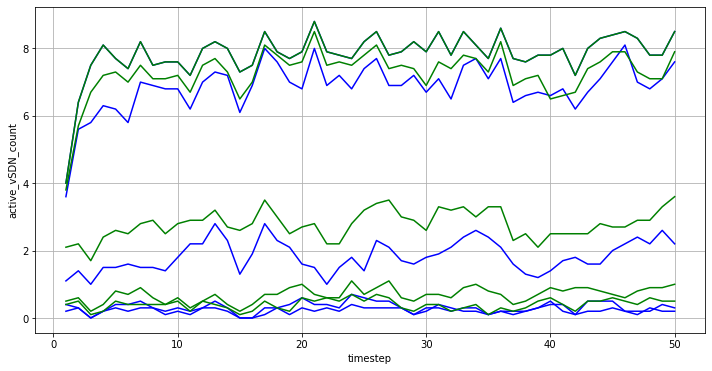

In [83]:
data = dfa
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.45"),color='b')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.4"),color='b')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.5"),color='b')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.55"),color='b')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.6"),color='b')

data = dfo
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.4"),color='g')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.45"),color='g')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.5"),color='g')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.55"),color='g')
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.6"),color='g')
plt.grid()

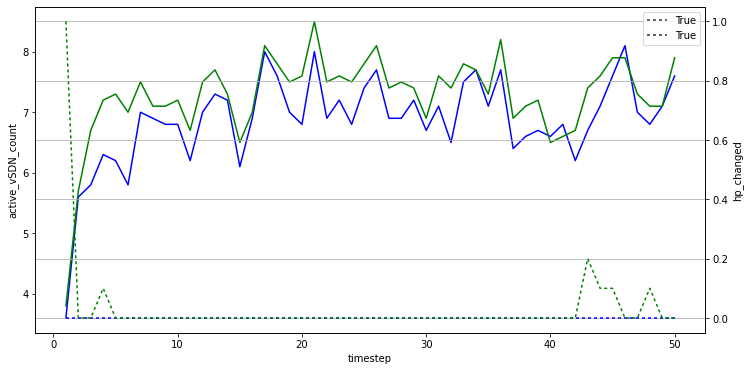

In [84]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

data = dfa
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.55"), color='blue', ax=ax)
sns.lineplot(x='timestep', y='hp_changed', data=data.query("latency_factor == 0.55"), color='blue', ax=ax2, style=True, dashes=[(2,2)])

data = dfo
sns.lineplot(x='timestep', y='active_vSDN_count', data=data.query("latency_factor == 0.55"), color='green', ax=ax)
sns.lineplot(x='timestep', y='hp_changed', data=data.query("latency_factor == 0.55"), color='green', ax=ax2, style=True, dashes=[(2,2)])
plt.grid()

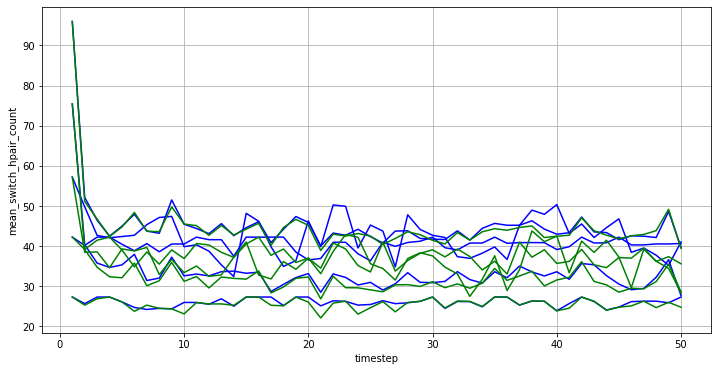

In [85]:
data = dfa
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.4"), color='blue')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.45"), color='blue')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.5"), color='blue')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.55"), color='blue')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.6"), color='blue')

data = dfo
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.4"), color='green')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.45"), color='green')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.5"), color='green')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.55"), color='green')
sns.lineplot(x='timestep', y='mean_switch_hpair_count', data=data.query("latency_factor == 0.6"), color='green')

plt.grid()

## Save data for latex/pgfplots

In [90]:
filename = "../results/26_usa/dynamic/2021-11-15-23-23-26_usa-ilp-opt.json"
df = pd.read_json(filename)
add_cumulative(df)
df = get_mean(df)
df['latency_factor'] = df['latency_factor'].round(2)

In [91]:
for simulation_name in df['simulation_name'].unique():
    df.query("`simulation_name` == @simulation_name").to_csv(f"{filename.rstrip('.json')}-{simulation_name}-mean.csv")